In [58]:
import requests
import pandas as pd
!pip install boto3
import boto3
import getpass
!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from datetime import datetime
!apt-get update
!apt install -y chromium-browser
!pip install selenium chromedriver-autoinstaller
import chromedriver_autoinstaller
import io
!pip install apache-airflow
from airflow import DAG
from airflow.operators.empty import EmptyOperator
from airflow.operators.python import PythonOperator
!pip install fastapi uvicorn
from pyspark.sql.functions import col,when,isnull
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from flask import Flask, jsonify

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [13]:
#Uso getpass para no mostrar la contraseña por seguridad
AWS_ACCESS_KEY = getpass.getpass("Introduce tu AWS Access Key: ")
AWS_SECRET_KEY = getpass.getpass("Introduce tu AWS Secret Key: ")
AWS_REGION = "eu-west-3"  # Region de paris

# Configurar el cliente de S3 con credenciales usuario IAM (Dar los permisos justos para su tarea)
s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=AWS_REGION
)

print("Conexión exitosa con AWS S3.")


Introduce tu AWS Access Key: ··········
Introduce tu AWS Secret Key: ··········
Conexión exitosa con AWS S3.


In [25]:
try:
        # Realizar una solicitud GET a la API de Jikan para obtener los mejores animes
        response = requests.get("https://api.jikan.moe/v4/top/anime")
        response.raise_for_status()  # Lanza un error si la respuesta falla
        response_data = response.json()  # Convertir la respuesta a JSON
except requests.exceptions.RequestException as e:
        print(f"Error al obtener datos: {e}")


# Lista para almacenar la información de los animes
anime_list = []

for anime in response_data['data']:
        anime_info = {
            "Titulo": anime['title'],
            "Edad Recomendada": anime['rating'],
            "Puntuación": anime['score'],
            "Resumen": anime['synopsis'],
            "Tipo": anime['type']
        }
        anime_list.append(anime_info)

# Convertir a DataFrame
df = pd.DataFrame(anime_list)

df.head()
#No haría falta usar selenium para scrapping pero como quería usarlo dejo aquí este que es el más óptimo

,Titulo,Edad Recomendada,Puntuación,Resumen,Tipo
0,Sousou no Frieren,PG-13 - Teens 13 or older,9.31,During their decade-long quest to defeat the D...,TV
1,Fullmetal Alchemist: Brotherhood,R - 17+ (violence & profanity),9.10,After a horrific alchemy experiment goes wrong...,TV
2,Steins;Gate,PG-13 - Teens 13 or older,9.07,Eccentric scientist Rintarou Okabe has a never...,TV
3,One Piece Fan Letter,PG-13 - Teens 13 or older,9.06,Although the golden age of piracy is about to ...,TV Special
4,Shingeki no Kyojin Season 3 Part 2,R - 17+ (violence & profanity),9.05,Seeking to restore humanity's diminishing hope...,TV


In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

df=pd.DataFrame()
# Extraer
def extract():
  chromedriver_autoinstaller.install() #Para que se adapte a colab

  options = webdriver.ChromeOptions()
  options.add_argument("--headless")  # Sin interfaz gráfica
  options.add_argument("--disable-gpu")  # Desactivar GPU
  options.add_argument("--no-sandbox")  # Evitar problemas en contenedores
  options.add_argument('User-Agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64)') # Por si deniegan el uso de bots

  # Iniciar el navegador con las opciones
  driver = webdriver.Chrome(options=options)

  # Realizar una solicitud GET a la API de Jikan para obtener los mejores animes
  response = requests.get("https://api.jikan.moe/v4/top/anime")
  response_data = response.json()  # Convertir la respuesta a JSON

  # Lista para almacenar la información de los animes
  anime_list = []

  for anime in response_data['data']:
    title = anime['title']  # Título del anime
    rating = anime['rating']  # Edad recomendada
    score = anime['score']  # Puntuación
    synopsis = anime['synopsis']  # Sinopsis
    type= anime['type'] # Tipo
    # Almacenar los datos en el diccionario
    anime_info = {
        "Title": title,
        "Rating": rating,
        "Score": score,
        "Synopsis": synopsis,
        "type": type
    }

    # Añadir la información del anime a la lista
    anime_list.append(anime_info)

  df=pd.DataFrame(anime_list)
  df.to_parquet("peliculas.parquet", index=False)
  # Cerrar el navegador
  driver.quit()
#Transformar
def transform():
    print("Transformando los datos...")
    df = pd.read_parquet("peliculas.parquet")
    df = df.drop_duplicates()  # Borrar duplicados
    df = df.dropna()  # Borrar vacíos

    # Crear la sesión de Spark
    spark = SparkSession.builder.appName("AnimeKNN").getOrCreate()
    df_spark = spark.createDataFrame(df)

    # Convertir 'Rating' a One-Hot Encoding usando Spark
    indexer = StringIndexer(inputCol="Rating", outputCol="RatingIndex")
    encoder = OneHotEncoder(inputCol="RatingIndex", outputCol="RatingVec")
    df_spark = indexer.fit(df_spark).transform(df_spark)
    df_spark = encoder.fit(df_spark).transform(df_spark)

    # Tokenizar el texto del 'Synopsis'
    tokenizer_synopsis = Tokenizer(inputCol="Synopsis", outputCol="words_synopsis")

    # Usar TF para convertir el texto en vectores numéricos
    hashingTF_synopsis = HashingTF(inputCol="words_synopsis", outputCol="raw_features_synopsis", numFeatures=1000)

    # Usar IDF para normalizar el TF
    idf_synopsis = IDF(inputCol="raw_features_synopsis", outputCol="features_synopsis")

    # Crear el Pipeline
    pipeline = Pipeline(stages=[tokenizer_synopsis, hashingTF_synopsis, idf_synopsis])

    # Entrenar el pipeline
    model = pipeline.fit(df_spark)

    # Transformar los datos
    df_spark_transformed = model.transform(df_spark)

    # Crear la columna final_features con RatingVec incluida
    assembler = VectorAssembler(inputCols=["features_synopsis", "RatingVec"], outputCol="final_features")
    df_spark_transformed = assembler.transform(df_spark_transformed)

    # Aplicar KMeans con k=5
    kmeans = KMeans(k=5, seed=1, featuresCol="final_features", predictionCol="prediction")
    kmeans_model = kmeans.fit(df_spark_transformed)
    predictions = kmeans_model.transform(df_spark_transformed)

    # Mostrar algunas predicciones
    predictions.select("Title","Score","Synopsis","prediction").show()
#Cargar
def load():
    print("Cargando los datos a la base de datos...")
    #convertimos a df y luego a parquet para guardar columnar y reducir el espacio
    df.to_parquet("peliculas.parquet", index=False)
  #Como estoy con colab se guarda temporal
    with open("peliculas.parquet", "rb") as file:
     s3.put_object(Bucket="rawcsvspro", Key="peliculas.parquet", Body=file)
     #Guardamos en el bucket s3 leyendo el archivo generado
     print("Parquet subido correctamente")

# DAG que se ejecuta diario
dag = DAG(
    'ETL_Pipeline',#Saldrá esto en airflow
    description='ETL pipeline for movies',
    schedule='@daily', #Ejecutar diario
    start_date=datetime(2025, 2, 12), #Empieza el día 12 (Presentación)
    catchup=False, #No ejecutar tareas no ejecutadas anteriormente
)

# Tareas
start = EmptyOperator(task_id='start', dag=dag)
#Proceso ETL
extract_task = PythonOperator(task_id='extract', python_callable=extract, dag=dag)
transform_task = PythonOperator(task_id='transform', python_callable=transform, dag=dag)
load_task = PythonOperator(task_id='load', python_callable=load, dag=dag)
#Los ejecuto así al no usar servidor, para pruebas pero debería de ir tareas y luego ejecutar el orden de la definición
extract()
transform()
load()
# Definir la secuencia de tareas
start >> extract_task >> transform_task >> load_task

Transformando los datos...
+--------------------+-----+--------------------+----------+
|               Title|Score|            Synopsis|prediction|
+--------------------+-----+--------------------+----------+
|   Sousou no Frieren| 9.31|During their deca...|         4|
|Fullmetal Alchemi...|  9.1|After a horrific ...|         1|
|         Steins;Gate| 9.07|Eccentric scienti...|         2|
|One Piece Fan Letter| 9.06|Although the gold...|         1|
|Shingeki no Kyoji...| 9.05|Seeking to restor...|         1|
|            Gintama°| 9.05|Gintoki, Shinpach...|         0|
|  Gintama: The Final| 9.04|Two years have pa...|         1|
|Hunter x Hunter (...| 9.03|Hunters devote th...|         1|
|            Gintama'| 9.02|After a one-year ...|         1|
| Gintama': Enchousen| 9.02|While Gintoki Sak...|         1|
|Ginga Eiyuu Densetsu| 9.01|The 150-year-long...|         1|
|Bleach: Sennen Ke...|  9.0|Substitute Soul R...|         1|
|Kaguya-sama wa Ko...| 8.99|The elite members...|         

<Task(PythonOperator): load>

In [59]:
#Iniciamos Flask
app = Flask(__name__)

# Ruta get animes para que el front tenga todo, saque los datos de aws s3, los pase a diccionarios y luego a json
@app.route('/get_animes', methods=['GET'])
def get_animes():
    try:
        # Cogemos de s3 que ya está inicializado
        response = s3.get_object(Bucket="rawcsvspro", Key="peliculas.parquet")

        # Leemos datos
        parquet_data = io.BytesIO(response['Body'].read())

        # Cargamos a dataframe
        df = pd.read_parquet(parquet_data)

        #Convertimos a diccionario que necesita JSON
        data = df.to_dict(orient='records')

        return jsonify(data)  # Devolvemos los datos en JSON

    except Exception as e:
        return jsonify({"error": str(e)}), 500  # Recogemos errores

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on
[2025-02-05T17:38:49.160+0000] {_internal.py:224} INFO - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
[2025-02-05T17:38:49.162+0000] {_internal.py:224} INFO - Press CTRL+C to quit
[2025-02-05T17:38:49.168+0000] {_internal.py:224} INFO -  * Restarting with stat


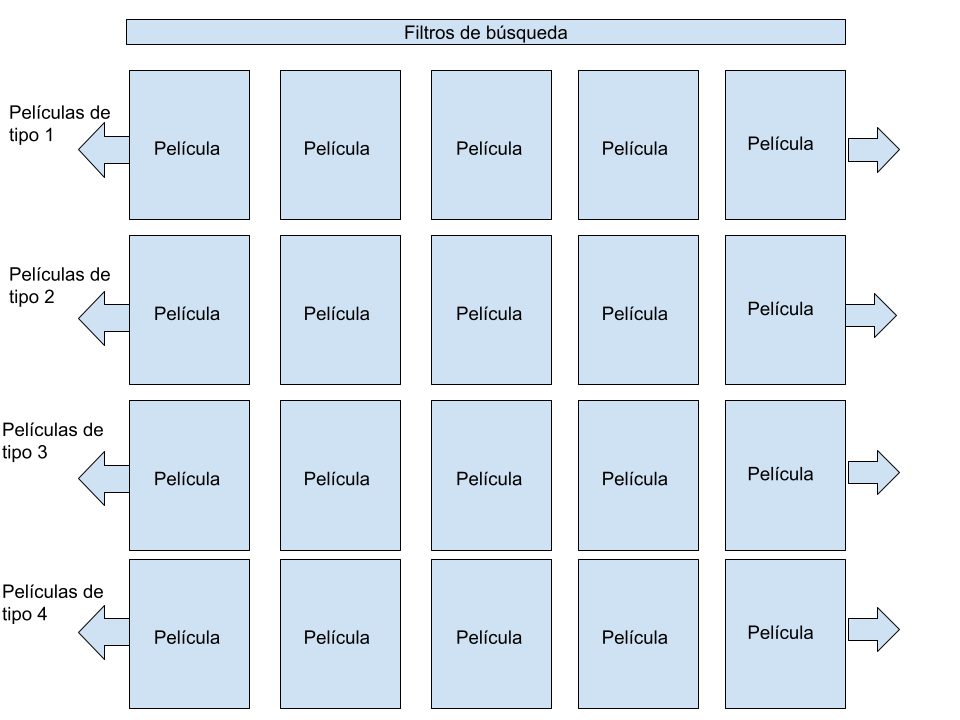

ASí es como quedaría el front, faltaria añadir la parte que recepciona el json y hace solicitudes post
